In [1]:
import os, json
from pathlib import Path
import datetime
import astropy.units as u
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np
import h5py

os.environ['OMP_NUM_THREADS']='16'

from pyampp0.query_sunpy     import download_closest_magnetograms
from pyampp0.ampp_compute    import ampp_field
from pyampp0.radio           import RadioImageComputing
from pyampp0.contrib.visuals import Box

In [2]:
conf_path = Path("./test_files.json").resolve()
data_path = (Path("./data")).resolve()

if not conf_path.exists():
    print("does not exist, using default parameters")
    ebtel_file = "/path/to/your/gx_simulator/userslib/aia/ebtel/ebtel.sav"
    jsoc_email = "test@example.com"
else:
    config = json.load(open(str(conf_path), "rb"))
    ebtel_file = config["ebtel_file"]
    jsoc_email = config["jsoc_email"]

In [3]:
dt = datetime.datetime(2024, 5, 5, 5, 0)
xc=285 # center of active region
yc=475

resolution = 700*u.km
model_path = "./model.h5"
data_path  = "./data/"

Navigate to <http://jsoc.stanford.edu/ajax/register_email.html> to register your mail

<https://docs.sunpy.org/en/stable/generated/api/sunpy.net.jsoc.JSOCClient.html>

Download ebtel file for radio source modeling here: <https://github.com/Gelu-Nita/GX_SIMULATOR/tree/master/userslib/ebtel>

In [4]:
#in_files = download_closest_magnetograms(dt, data_path, jsoc_email)
#in_files

In [5]:
# box (x=128, y=64, z=64) x 700 km

ampp_field(data_path, model_path, xc, yc, 128, 64, 64, res=resolution)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


opening file
NLFFF energy:     1.6929159269766023e+32 erg
Calculating field lines
cutoff_qs:  0.991392949634659 1003
cutoff_b:  1.0160090636373977
cutoff_f:  1.0359026067367256
umbra: nelem=  1066  abs(B) range:  4.134217929830154 1761.6771372266035
penumbra: nelem=  2041  abs(B) range:  0.16699691493248664 1100.8657483968557
eNW: nelem=  153  abs(B) range:  0.5800714707914201 463.9385530280463
NW: nelem=  1118  abs(B) range:  0.03954448135178388 426.09131414242046
IN: nelem=  3814  abs(B) range:  0.016618412613616455 699.170757691664
plage: nelem=  2547  abs(B) range:  30.000891663325778 600.159185554152
facula: nelem=  1647  abs(B) range:  30.000891663325778 495.6912713128649
Total elements:  12386
Number of elements in cont:  8192


In [6]:
vis_box = Box(model_path, resolution)
#vis_box.open_window()

[ 64 128  64]


### Plotting magnetic field

In [7]:
field_model = h5py.File(model_path, "r")

bx, by, bz = [field_model["nlfff"][x][:] for x in ("by", "by", "bz")]
bx_pot, by_pot, bz_pot = [field_model["potential"][x][:] for x in ("by", "by", "bz")]

field_model.close()

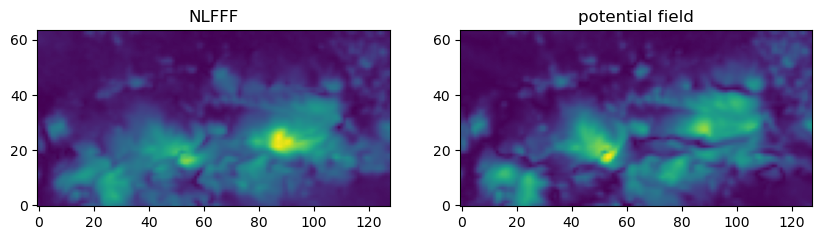

In [8]:
b_abs = np.sqrt(bx**2 + by**2 + bz**2)
b_abs_pot = np.sqrt(bx_pot**2 + by_pot**2 + bz_pot**2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(b_abs[0, :, :].T, origin="lower") # warning: nlfff is transposed differently: check it!
ax2.imshow(b_abs_pot[0, :, :], origin="lower")

for ax, lbl in zip((ax1, ax2), ("NLFFF", "potential field")):
    ax.set_title(lbl)

fig.show()

### Creating a model of GR radiosource

In [9]:
gxi = RadioImageComputing()

ebtel, ebtel_dt = gxi.load_ebtel(ebtel_file) # get ebtel file from GX Simulator!
model, model_dt = gxi.load_model_hdf(model_path) # internal representation to pass to C++ code

In [10]:
box_Nx=150
box_Ny=150
box_dx=1.0 # resolution in arcsec/pixel
box_dy=1.0

freqlist=[5.0, 7.0] # GHz

Tbase=1e6
nbase=1e8
Q0=4.5e-3
a=1.5
b=2.5

results = gxi.synth_model(model, model_dt,
                          ebtel, ebtel_dt, freqlist,
                          box_Nx, box_Ny, xc, yc, box_dx, box_dy, Tbase, nbase, Q0, a, b, force_isothermal=1)

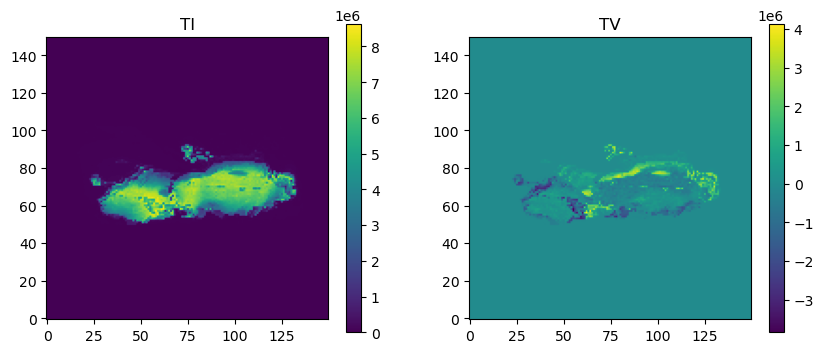

In [11]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
i1 = ax1.imshow(results["TI"][:, :, 0].T, origin='lower')
i2 = ax2.imshow(results["TV"][:, :, 0].T, origin='lower')

plt.colorbar(i1, ax=ax1)
plt.colorbar(i2, ax=ax2)
ax1.set_title("TI")
ax2.set_title("TV")

plt.show()